# Multiparametric Imaging: Quickstart

[![View on GitHub](https://img.shields.io/badge/View-on%20GitHub-lightgrey?logo=github)](https://github.com/Dana-Farber-AIOS/pathml/blob/master/examples/multiplex_if.ipynb)

Pathology imaging experiments commonly produce data where each channel corresponds to a molecular feature, such as the expression level of a protein or nucleic acid. PathML implements MultiparametricSlide, a subclass of SlideData for which we implement special transforms (for more information about transforms, see "Creating Preprocessing Pipelines" in our documentation). 

MultiparametricSlide is the appropriate type to analyze low-dimensional techniques including immunofluoresence (protein and in situ hybridization/RNAscope). Recently multiple approaches to higher dimensional imaging of 'spatial omics', the simultaneous measurement of a large number of molecular features, have emerged (see https://www.nature.com/articles/s41592-020-01033-y, https://pubmed.ncbi.nlm.nih.gov/30078711/, among many others). 

In this notebook we run a pipeline to analyze CODEX data to demonstrate PathML's support for multiparametric imaging data.

We use the MultiparametricSlide subclass, CODEXSlide, which supports special preprocessing transformations for the CODEX technique. See "Convenience SlideData Classes" (https://pathml.readthedocs.io/en/latest/api_core_reference.html#convenience-slidedata-classes) to see other subclasses that we have implemented. 

In [1]:
import os

os.environ["JAVA_HOME"] = "/opt/conda/envs/pathml/"

# load libraries and data
from pathml.core.slide_data import CODEXSlide
from pathml.preprocessing.pipeline import Pipeline
from pathml.preprocessing.transforms import SegmentMIF, QuantifyMIF, CollapseRunsCODEX

import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client
from deepcell.utils.plot_utils import make_outline_overlay
from deepcell.utils.plot_utils import create_rgb_image


import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

slidedata = CODEXSlide("../../data/data/reg031_X01_Y01.tif")

Here we analyze a TMA from Schurch et al., *Coordinated Cellular Neighborhoods Orchestrate Antitumoral Immunity at the Colorectal Cancer Invasive Front* (Cell, 2020)

Below are the proteins measured in this TMA and the cell types they label. CODEX images proteins in cycles of 3, so here we list proteins by cycle.

| Cycle | Protein 1 | Protein 2 | Protein 3 |
| :- | :- | :- | :- |
| HOECHST1 | blank | blank | blank | 
| HOECHST2 | CD44 - stroma | FOXP3 - regulatory T cells | CDX2 - intestinal epithelia |
| HOECHST3 | CD8 - cytotoxic T cells | p53 - tumor suppressor | GATA3 - Th2 helper T cells |
| HOECHST4 | CD45 - hematopoietic cells | T-bet - Th1 cells | beta-catenin - Wnt signaling |
| HOECHST5 | HLA-DR - MHC-II | PD-L1 - checkpoint | Ki67 - proliferation | 
| HOECHST6 | CD45RA - naive T cells | CD4 - T helper cells | CD21 - DCs | 
| HOECHST7 | MUC-1 - epithelia | CD30 - costimulator | CD2 - T cells | 
| HOECHST8 | Vimentin - cytoplasm | CD20 - B cells | LAG-3 - checkpoint | 
| HOECHST9 | Na-K-ATPase - membranes | CD5 - T cells | IDO-1 - metabolism | 
| HOECHST10 | Cytokeratin - epithelia | CD11b - macrophages | CD56 - NK cells | 
| HOECHST11 | aSMA - smooth muscle | BCL-2 - apoptosis | CD25 - IL-2 Ra | 
| HOECHST12 | Collagen IV - bas. memb. | CD11c - DCs | PD-1 - checkpoint | 
| HOCHST13 | Granzyme B - cytotoxicity | EGFR - signaling | VISTA - costimulator | 
| HOECHST14 | CD15 - granulocytes | CD194 - CCR4 chemokine R | ICOS - costimulator | 
| HOECHST15 | MMP9 - matrix metalloproteinase | Synaptophysin - neuroendocrine | CD71 - transferrin R | 
| HOECHST16 | GFAP - nerves | CD7 - T cells | CD3 - T cells | 
| HOECHST17 | Chromogranin A - neuroendocrine | CD163 - macrophages | CD57 - NK cells | 
| HOECHST18 | empty - A488_18 | CD45RO - memory cells | CD68 - macrophages | 
| HOECHST19 | empty - A488_19 | CD31 - vasculature | Podoplanin - lymphatics | 
| HOECHST20 | empty-A488-20 | CD34 - vasculature | CD38 - multifunctional | 
| HOECHST21 | empty-A488-21 | CD138 - plasma cells | MMP12 - matrix metalloproteinase | 
| HOECHST22 | empty-A488-22 | empty-Cy3-22 | empty-Cy5-22 | 
| HOECHST23 | empty-A488-23 | empty-Cy3-23 | DRAQ5 | 

In [2]:
# These tif are of the form (x,y,z,c,t) but t is being used to denote cycles
# 17 z-slices, 4 channels per 23 cycles, 70 regions
slidedata.slide.shape

(1440, 1920, 17, 4, 23)

## Defining a Multiparametric Pipeline

We define a pipeline that chooses a z-slice from our CODEX image, segments cells in the image, then quantifies the expression of each protein in each cell. 

In [3]:
# 31 -> Na-K-ATPase
pipe = Pipeline(
    [
        CollapseRunsCODEX(z=6),
        SegmentMIF(
            model="mesmer",
            nuclear_channel=0,
            cytoplasm_channel=31,
            image_resolution=0.377442,
        ),
        QuantifyMIF(segmentation_mask="cell_segmentation"),
    ]
)
client = Client()
slidedata.run(pipe, distributed=True, client=client, tile_size=1000, tile_pad=False);

2024-02-14 16:33:05.572790: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/envs/pathml/lib/python3.9/site-packages/cv2/../../lib64:/opt/conda/envs/pathml/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-02-14 16:33:05.572836: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-02-14 16:33:05.572863: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (puchala-dxvm): /proc/driver/nvidia/version does not exist
2024-02-14 16:33:05.573264: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-cri

In [4]:
img = slidedata.tiles[0].image

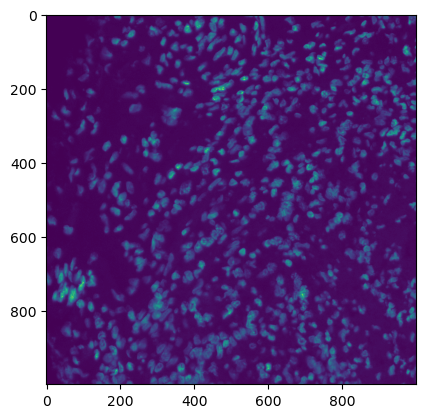

In [5]:
plt.imshow(img[:, :, 7])

In [6]:
def plot(slidedata, tile, channel1, channel2):
    image = np.expand_dims(slidedata.tiles[tile].image, axis=0)
    nuc_segmentation_predictions = np.expand_dims(
        slidedata.tiles[tile].masks["nuclear_segmentation"], axis=0
    )
    cell_segmentation_predictions = np.expand_dims(
        slidedata.tiles[tile].masks["cell_segmentation"], axis=0
    )
    # nuc_cytoplasm = np.expand_dims(np.concatenate((image[:,:,:,channel1,0], image[:,:,:,channel2,0]), axis=2), axis=0)
    nuc_cytoplasm = np.stack(
        (image[:, :, :, channel1], image[:, :, :, channel2]), axis=-1
    )
    rgb_images = create_rgb_image(nuc_cytoplasm, channel_colors=["blue", "green"])
    overlay_nuc = make_outline_overlay(
        rgb_data=rgb_images, predictions=nuc_segmentation_predictions.astype("uint8")
    )
    overlay_cell = make_outline_overlay(
        rgb_data=rgb_images, predictions=cell_segmentation_predictions.astype("uint8")
    )
    fig, ax = plt.subplots(1, 2, figsize=(15, 15))
    ax[0].imshow(rgb_images[0, ...])
    ax[1].imshow(overlay_cell[0, ...])
    ax[0].set_title("Raw data")
    ax[1].set_title("Cell Predictions")
    plt.show()

Let's check the quality of our segmentations in a 1000x1000 pixel tile by looking at DAPI, Syp, and CD44. 

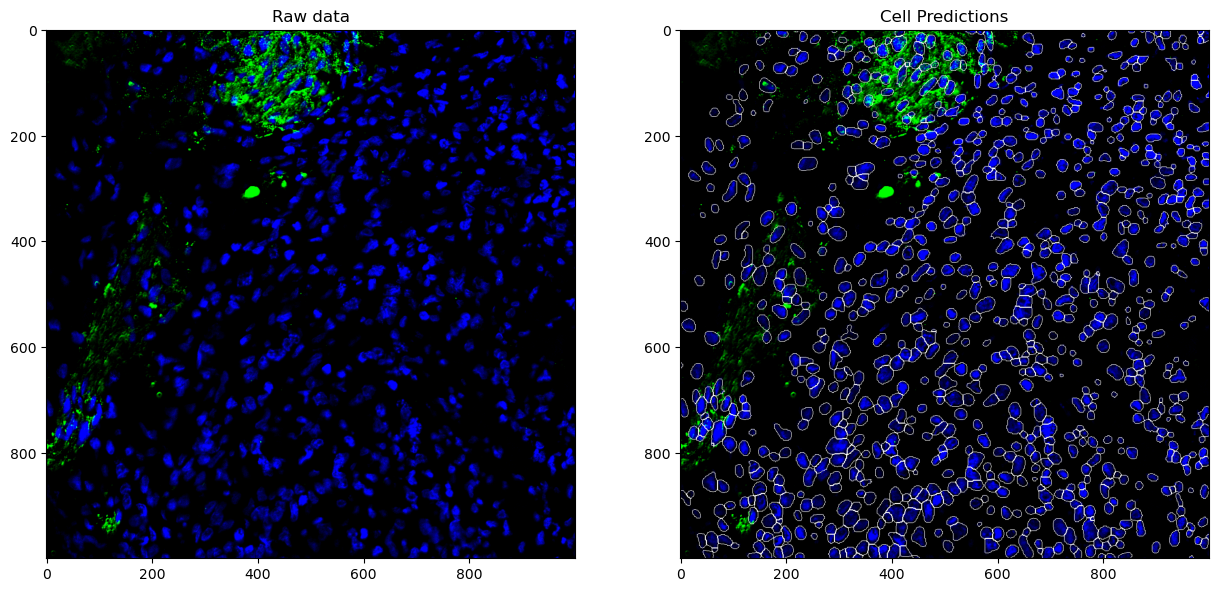

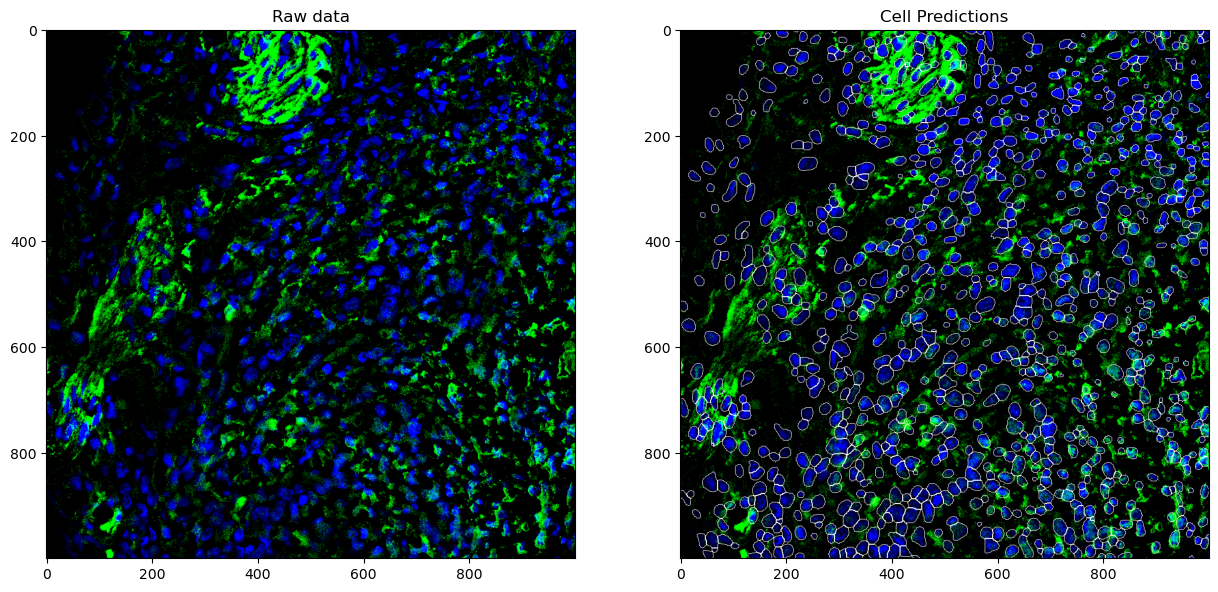

In [7]:
# DAPI + Syp
plot(slidedata, tile=0, channel1=0, channel2=60)

# DAPI + CD44
plot(slidedata, tile=0, channel1=0, channel2=24)

## AnnData Integration and Spatial Single Cell Analysis

Now let's explore the single-cell quantification of our imaging data. Our pipeline produced a single-cell matrix of shape (cell x protein) where each cell has attached additional information including location on the slide and the size of the cell in the image. This information is stored in slidedata.counts as an anndata object (https://anndata.readthedocs.io/en/latest/anndata.AnnData.html).

In [8]:
adata = slidedata.counts.to_memory()

In [9]:
adata

AnnData object with n_obs × n_vars = 945 × 92
    obs: 'y', 'x', 'label', 'filled_area', 'euler_number'
    obsm: 'spatial'
    layers: 'min_intensity', 'max_intensity'

In [10]:
adata.X

array([[ 8.11290323, 10.98387097, 11.72580645, ...,  0.        ,
         0.        , 21.77419355],
       [10.15277778, 10.90277778, 11.33333333, ...,  0.        ,
         0.        , 23.61111111],
       [20.5       , 17.19642857, 18.51785714, ...,  0.        ,
         0.        , 24.25      ],
       ...,
       [ 9.68345324, 12.20143885, 12.55395683, ...,  0.        ,
         0.        , 12.07913669],
       [ 4.31666667,  8.48333333,  8.65      , ...,  0.        ,
         0.        ,  7.31666667],
       [10.06896552,  8.89655172,  8.79310345, ...,  0.        ,
         0.        ,  8.55172414]])

In [11]:
adata.obs

,y,x,label,filled_area,euler_number
0,2.048387,219.290323,1,62.0,1
1,2.666667,291.402778,2,72.0,1
2,2.535714,873.107143,3,56.0,1
3,3.729885,550.339080,4,174.0,1
4,3.242105,853.084211,5,95.0,1
...,...,...,...,...,...
940,994.813853,842.056277,941,231.0,1
941,995.741935,336.379032,942,124.0,1
942,995.589928,812.503597,943,139.0,1
943,997.083333,444.583333,944,60.0,1


In [12]:
adata.var

""
0
1
2
3
4
...
87
88
89
90


This anndata object gives us access to the entire python (or Seurat) single cell analysis ecosystem of tools. We follow a single cell analysis workflow described in https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html and https://www.embopress.org/doi/full/10.15252/msb.20188746. 

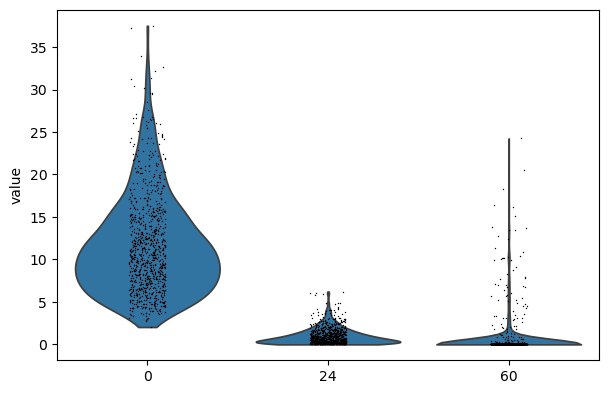

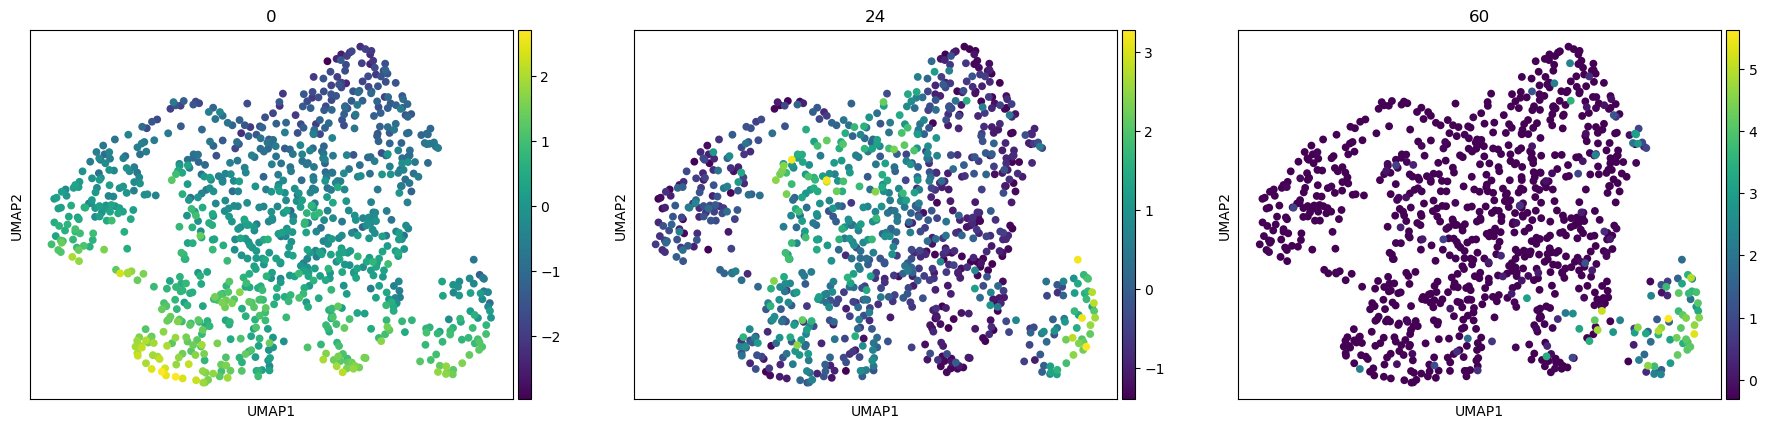

In [13]:
import scanpy as sc

sc.pl.violin(adata, keys=["0", "24", "60"])
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["0", "24", "60"])

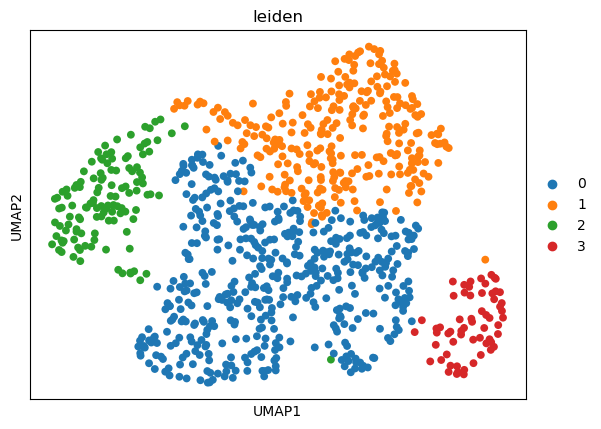

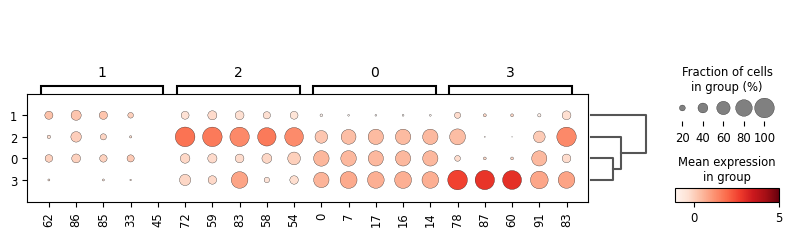

In [16]:
sc.tl.leiden(adata, resolution=0.15)
sc.pl.umap(adata, color="leiden")
sc.tl.rank_genes_groups(adata, "leiden", method="t-test")
sc.pl.rank_genes_groups_dotplot(adata, groupby="leiden", vmax=5, n_genes=5)

We can also use spatial analysis tools such as https://github.com/theislab/squidpy.

In [19]:
import scanpy as sc
import squidpy as sq

sc.pl.spatial(adata, color="leiden", spot_size=15)
sc.pl.spatial(adata, color="leiden", groups=["2", "4"], spot_size=15)

  0%|          | 0/1 [00:00<?, ?/s]

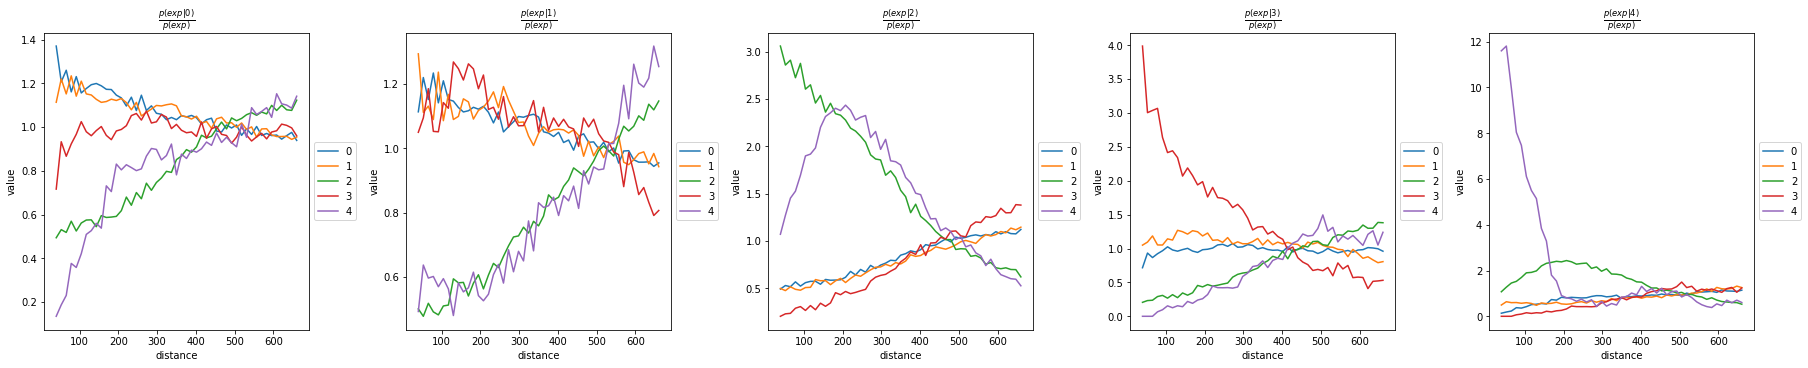

In [15]:
sq.gr.co_occurrence(adata, cluster_key="leiden")
sq.pl.co_occurrence(adata, cluster_key="leiden")

## References

* Schürch, C.M., Bhate, S.S., Barlow, G.L., Phillips, D.J., Noti, L., Zlobec, I., Chu, P., Black, S., Demeter, J., McIlwain, D.R. and Samusik, N., 2020. Coordinated cellular neighborhoods orchestrate antitumoral immunity at the colorectal cancer invasive front. Cell, 182(5), pp.1341-1359.